### The accuracy is shit so here some things to try:
- [ ] More data?
- [ ] Different date feature engineering approach
- [ ] Remove/leave pollutant
- [ ] Model ensembling
- [ ] Use random forests


Compare results with https://aqicn.org/city/montreal/

In [89]:
import pandas as pd
import os
from fastai.tabular.all import *

def get_csv(url, local_filename):
    if not os.path.exists(local_filename):
        print(f"{local_filename} not found locally. Downloading and reading from URL...")
        df = pd.read_csv(url)
        df.to_csv(local_filename, index=False)  # Save the downloaded file locally
    else:
        print(f"Reading {local_filename} from local storage...")
        df = pd.read_csv(local_filename)
    return df

In [90]:
df1 = get_csv('https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/0c325562-e742-4e8e-8c36-971f3c9e58cd/download/rsqa-indice-qualite-air-2022-2024.csv', '2019-2021.csv')
df2 = get_csv('https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/e43dc1d6-fbdd-49c3-a79f-83f63404c281/download/rsqa-indice-qualite-air-2019-2021.csv', '2012-2024.csv')

Reading 2019-2021.csv from local storage...
Reading 2012-2024.csv from local storage...


In [93]:
df = pd.concat([df1, df2])

In [94]:
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['heure'].astype(str) + ':00:00',
                                format = '%Y-%m-%d %H:%M:%S',
                                errors = 'coerce')
df.drop(["heure", "date", "polluant"], axis=1, inplace=True)
df.sort_values("datetime", inplace=True)

# Taking a sample of data for a given datetime and station id
df[(df["stationId"] == 103) & (df["datetime"] == "2024-04-15 19:00:00")]

,stationId,valeur,datetime
769491,103,2,2024-04-15 19:00:00
769490,103,24,2024-04-15 19:00:00
769492,103,5,2024-04-15 19:00:00


In [95]:
# the data contains measurements across various stations (spread over the MTL territory).
# We can take the maximum measurement for a given station for a given datetime (regardless of the pollutant).
# Note: we are assuming each pollutant contributes equally to the AQI level
# (Using the maximum pollutant value as a representative AQI is simplistic. Real AQI calculation may involve more complex computations where different pollutants have different weights or scale adjustments based on their health impact.)
group1_df = df.groupby(['stationId', 'datetime']).max()

# Manually verifying the maximum has been taken for a given station id on a given datetime
group1_df.loc[(103, "2024-04-15 19:00:00")]

valeur    24
Name: (103, 2024-04-15 19:00:00), dtype: int64

In [96]:
# Get the mean across all station maximums for each datetime
group2_df = group1_df.groupby("datetime").mean()

# Manually verifying the mean of a give datetime across all stations
group2_df.loc["2024-04-15 19:00:00"], group1_df.xs("2024-04-15 19:00:00", level='datetime')

(valeur    22.818182
 Name: 2024-04-15 19:00:00, dtype: float64,
            valeur
 stationId        
 3              25
 6              25
 17             26
 28             21
 31             25
 50              5
 55             26
 66             24
 80             25
 99             25
 103            24)

In [97]:
group2_df['year'] = group2_df.index.year

# Year has a bigger number range than the rest so we divide it up by its maximum
group2_df['year'] = group2_df['year'] / group2_df['year'].max()
group2_df['month'] = group2_df.index.month
group2_df['day'] = group2_df.index.day
group2_df['weekday'] = group2_df.index.weekday
group2_df['hour'] = group2_df.index.hour

group2_df

,valeur,year,month,day,weekday,hour
datetime,,,,,,
2019-01-01 00:00:00,33.454545,0.99753,1,1,1,0
2019-01-01 01:00:00,28.181818,0.99753,1,1,1,1
2019-01-01 02:00:00,19.363636,0.99753,1,1,1,2
2019-01-01 03:00:00,13.454545,0.99753,1,1,1,3
2019-01-01 04:00:00,10.909091,0.99753,1,1,1,4
...,...,...,...,...,...,...
2024-04-16 19:00:00,22.545455,1.00000,4,16,1,19
2024-04-16 20:00:00,21.181818,1.00000,4,16,1,20
2024-04-16 21:00:00,20.545455,1.00000,4,16,1,21


In [98]:
split_date_valid = pd.Timestamp('2023-01-01')
split_date_test = pd.Timestamp('2024-01-01')

train_idx = group2_df.index < split_date_valid
valid_idx = (group2_df.index >= split_date_valid) & (group2_df.index < split_date_test)
test_idx = group2_df.index >= split_date_test

train_idxs = np.where(train_idx)[0].tolist()
valid_idxs = np.where(valid_idx)[0].tolist()
test_idxs = np.where(test_idx)[0].tolist()

In [99]:
final_df = group2_df.reset_index()
dls = TabularPandas(
  final_df,
  procs=[Normalize],
  cat_names=[],
  cont_names=['year', 'month', 'day', 'weekday', 'hour'],
  y_names=['valeur'],
  splits=(train_idxs, valid_idxs),
  y_block=RegressionBlock()
).dataloaders(bs=500)

dls.show_batch()

,year,month,day,weekday,hour,valeur
0,0.998518,4.0,14.0,2.0,1.200000e+01,18.363636
1,0.998518,10.0,19.0,1.0,1.300000e+01,11.818182
2,0.997530,1.0,16.0,2.0,1.200000e+01,13.545455
3,0.997530,1.0,9.0,2.0,5.000000e+00,15.727273
4,0.999012,12.0,13.0,1.0,2.200000e+01,18.200001
5,0.997530,1.0,17.0,3.0,2.100000e+01,20.700001
6,0.997530,2.0,13.0,2.0,1.800000e+01,20.799999
7,0.998024,7.0,22.0,2.0,6.318183e-08,8.000000
8,0.997530,5.0,2.0,3.0,1.300000e+01,20.500000
9,0.998518,9.0,9.0,3.0,4.000000e+00,15.272727


In [ ]:
learn = tabular_learner(dls, metrics=mae, layers=[10, 10])

SuggestedLRs(valley=0.0831763744354248, slide=6.309573450380412e-07)

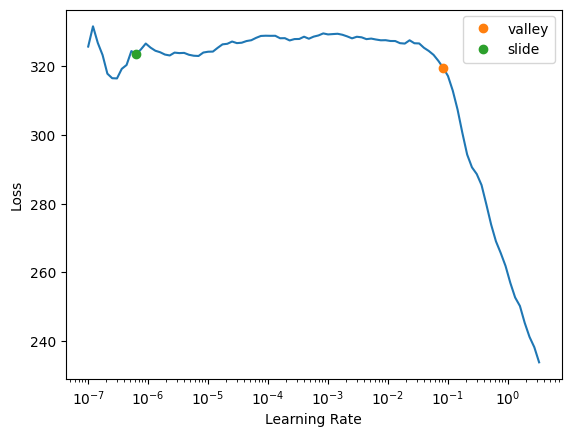

In [ ]:
learn.lr_find(suggest_funcs=[valley, slide])

In [ ]:
learn.fit_one_cycle(10, 0.01)

epoch,train_loss,valid_loss,mae,time
0,339.485229,555.227295,19.552158,00:00
1,254.825531,303.815613,11.572350,00:00
2,91.848442,173.878052,5.285465,00:00
3,45.516136,178.121918,5.379152,00:00
4,34.107075,177.239517,5.370776,00:00
5,31.260065,176.518005,5.347787,00:00
6,30.729376,175.933212,5.329877,00:00
7,29.955696,175.814468,5.344556,00:01
8,29.833557,176.014709,5.346324,00:01
9,30.176470,176.446884,5.354661,00:01


In [ ]:
# learn.recorder.plot_loss()
learn.show_results(max_n=10)

,year,month,day,weekday,hour,valeur,valeur_pred
0,2.236987,1.588154,-0.423818,-1.000857,1.083473,13.909091,15.054518
1,2.236987,-0.441595,-0.196548,1.501285,1.083473,24.818182,17.823792
2,2.236987,1.588154,-0.991994,0.000000,-0.216695,13.636364,13.552986
3,2.236987,1.008225,0.485263,0.500428,0.216695,21.727272,13.715446
4,2.236987,1.008225,0.371628,0.000000,-0.505621,12.727273,13.184334
5,2.236987,-1.311487,-0.082912,-0.500428,0.072232,19.363636,17.568426
6,2.236987,0.718261,0.826169,1.000857,-0.505621,18.181818,12.536079
7,2.236987,1.298190,-1.446535,0.500428,-1.083473,13.363636,12.975909
8,2.236987,-0.731559,1.167074,-0.500428,-0.216695,22.090910,15.794241
9,2.236987,-0.151631,0.826169,0.500428,-0.939010,12.272727,13.397153


# Run test set

In [ ]:
df_test = final_df.loc[test_idxs]
test_dl = dls.test_dl(df_test)
preds, targets = learn.get_preds(dl=test_dl)

In [ ]:
# Comparing
df = pd.DataFrame({'datetime': df_test['datetime'],
              'Actual': df_test['valeur'],
              'Predicted': preds.flatten() })

df['Percentage Error'] = np.abs(df['Actual'] - df['Predicted']) / df['Actual'] * 100

df

,datetime,Actual,Predicted,Percentage Error
43824,2024-01-01 00:00:00,15.727273,19.329197,22.902408
43825,2024-01-01 01:00:00,16.272727,19.087597,17.298081
43826,2024-01-01 02:00:00,17.090909,18.845999,10.269142
43827,2024-01-01 03:00:00,17.636364,18.604401,5.488870
43828,2024-01-01 04:00:00,18.272727,18.362801,0.492939
...,...,...,...,...
46363,2024-04-15 19:00:00,22.818182,16.063654,29.601517
46364,2024-04-15 20:00:00,21.181818,15.912877,24.874829
46365,2024-04-15 21:00:00,19.272727,15.868380,17.664068
46366,2024-04-15 22:00:00,19.727273,15.823882,19.786773
